In [1]:
import csv
import typing as tp
import pickle
from collections import defaultdict
import random

import epitran
import eng_to_ipa
import numpy as np
import keras
import re
import keras.layers
import keras.optimizers
import keras.callbacks
from hyphen import Hyphenator
from Levenshtein import distance as lev
from matplotlib import pyplot as plt
from keras.utils import pad_sequences, to_categorical
from keras.preprocessing.text import Tokenizer
from tqdm import tqdm


In [2]:
MODEL_NAME = 'RhymeModelPOL'
POL = True if MODEL_NAME.endswith('POL') else False

TO_EXCLUDE = '!"#$%&()*+-—/:;<=>@[\\]^_`{|}~.,:;!?\t«»\''
TO_TOKENIZE = '\n'

In [9]:
def load_data(file, include: str, exclude: str, size: int = None):
    _text =  []
    with open(file, encoding='UTF-8') as f:
        data = csv.reader(f)
        for verse, *_ in tqdm(list(data)[:size] if size is not None else list(data)):
            # Separate characters that we want to tokenize
            correct_verse = re.sub(r'(['+include+'])', r' \1 ', verse)
            # Exclude characters that we do not want to tokenize
            correct_verse = correct_verse.translate(str.maketrans('', '', exclude))
            _text.append(correct_verse.lower())
    return _text

if POL:
    TEXT = load_data('data/poems/pl/kochanowski.csv', TO_TOKENIZE, TO_EXCLUDE)
    TEXT += load_data('data/poems/pl/slowacki.csv', TO_TOKENIZE, TO_EXCLUDE)
    TEXT += load_data('data/poems/pl/tacohemingway.csv', TO_TOKENIZE, TO_EXCLUDE)
    TEXT += load_data('data/poems/pl/ostr.csv', TO_TOKENIZE, TO_EXCLUDE)
else:
    TEXT = load_data('data/poems/eng/limericks.csv', TO_TOKENIZE, TO_EXCLUDE, 20000)
print(*TEXT[:3])
new_line = '\n'
print(f"Number of lines: {sum([len(poem.split(new_line)) for poem in TEXT])}")

100%|██████████| 40/40 [00:00<00:00, 3037.04it/s]

tobie bądź chwała panie wszego świata 
 żeś nam doczekać dał nowego lata 
 daj byśmy się i sami odnowili 
 grzech porzuciwszy  w niewinności żyli 
 łaska twa święta niechaj będzie z nami 
 bo nic dobrego nie uczynim sami 
 mnóż w nas nadzieję przyspórz prawej wiary 
 niech uważamy twe prawdziwe dary 
 użycz pokoju nam i świętej zgody 
 niech się nas boją pogańskie narody 
 a ty nas nie chciej odstępować panie 
 i owszem racz nam dopomagać na nie 
 błogosław ziemi z twej szczodrobliwości 
 niechaj nam dawa dostatek żywności 
 uchowaj głodu i powietrza złego 
 daj wszystko dobre z miłosierdzia swego 
  prózno uciec prózno się przed miłością schronić 
 bo jako lotny nie ma pieszego dogonić 
  kupić by cię mądrości za drogie pieniądze 
 która jesli prawdziwie mienią wszytki żądze 
 wszytki ludzkie frasunki umiesz wykorzenić 
 a człowieka tylko nie w anioła odmienić 
 który nie wie co boleść frasunku nie czuje 
 złym przygodom nie podległ strachom nie hołduje 
 ty wszytki rzeczy ludzkie mas

In [4]:
def rhyme_levenshtein(token1: str, token2: str, pl: bool):
    token1 = token1.lower()
    token2 = token2.lower()

    available_swaps = [
        ("p", "b"), ("w", "f"), ("ó", "u"), ("ę", "e"), ("r", "l"), ("d", "t"), ("ą", "o"), ("b", "t"), ("g", "k"), ("i", "j")
    ] if pl else []
    available_swaps.extend([(v, k) for k, v in available_swaps])

    distances = np.zeros((len(token1) + 1, len(token2) + 1))

    for t1 in range(len(token1) + 1):
        distances[t1][0] = t1

    for t2 in range(len(token2) + 1):
        distances[0][t2] = t2

    for t1 in range(1, len(token1) + 1):
        for t2 in range(1, len(token2) + 1):
            letter1 = token1[t1 - 1]
            letter2 = token2[t2 - 1]
            if letter1 == letter2 or (letter1, letter2) in available_swaps:
                distances[t1][t2] = distances[t1 - 1][t2 - 1]
            else:
                a = distances[t1][t2 - 1]
                b = distances[t1 - 1][t2]
                c = distances[t1 - 1][t2 - 1]

                if a <= b and a <= c:
                    distances[t1][t2] = a + 1
                elif b <= a and b <= c:
                    distances[t1][t2] = b + 1
                else:
                    distances[t1][t2] = c + 1
    return distances[len(token1)][len(token2)]

def rhyme_levenshtein_measure(word1: str, word2: str, pl: bool, syllables: int = 2):
    hyphenator = Hyphenator('pl_PL' if pl else 'en_US')
    syllable1 = ''.join(hyphenator.syllables(word1)[-syllables:])
    syllable2 = ''.join(hyphenator.syllables(word2)[-syllables:])
    distance = rhyme_levenshtein(syllable1, syllable2, pl)
    return 1 - (distance / max(len(syllable1), len(syllable2)))

print(rhyme_levenshtein_measure("Żaby", "Mapy", True))
print(rhyme_levenshtein_measure("Piekarni", "Przyćmionej", True))
print(rhyme_levenshtein_measure("sweet", "meet", False))

0.75
0.33333333333333337
0.6


In [5]:
def extract_rhymes(_text: tp.List[str], rhyme_scheme: str = None):
    rhymes_dict = defaultdict(list)

    def find_rhyme_words(rhyme: str, n_last_words: tp.List[str], threshold: float = 0.5):
        reduced_words = [w for w in n_last_words if w[-1] == rhyme[-1]]
        scores = [(rhyme_levenshtein_measure(rhyme, w, POL), w) for w in reduced_words]
        scores = [score for score in scores if score[0] > threshold]
        return [s[1] for s in scores]

    def add_rhymes(_rhyme_words: tp.List[str]):
        for word in _rhyme_words:
            others = _rhyme_words.copy()
            reduce_letters = "ňňéöĺéôľ"
            others = [w for w in others if w != word and not any([letter in w for letter in reduce_letters])]
            rhymes_dict[word].extend(others)

    print(f"Number of poems: {len(_text)}")
    for verse_number, verse in tqdm(enumerate(_text)):
        lines = [l for l in verse.strip().split('\n') if l.strip()]
        try:
            last_words = [line.strip().split(' ')[-1] for line in lines]
            if rhyme_scheme:
                if len(last_words) != len(rhyme_scheme):
                    raise IndexError
                rhymes_by_letter = defaultdict(list)
                [rhymes_by_letter[letter].append(word) for letter, word in zip(rhyme_scheme, last_words)]
                [add_rhymes(rhyme) for rhyme in rhymes_by_letter.values()]
            else:
                for index, word in enumerate(last_words):
                    n_words = last_words[max(index - 3, 0):index]
                    rhyme_words = find_rhyme_words(word, n_words)
                    add_rhymes([word, *rhyme_words])

        except IndexError as e:
            print(f"Invalid verse with number {verse_number} {e}")
            continue
    return {k: list(set(v)) for k, v in rhymes_dict.items()}

RHYMES = extract_rhymes(TEXT, None if POL else "AABBA") # For english limericks use "AABBA" schema
print(f"Size of vocabulary: {len(RHYMES)}")
MINIMUM_OCCURRENCES = 1 if POL else 6
RHYMES = {k:v for k, v in RHYMES.items() if len(v) >= MINIMUM_OCCURRENCES}
print(f"Size of reduced vocabulary: {len(RHYMES)}")

print("...")
print(*[f"{k}: {v}\n" for k, v in sorted(RHYMES.items())[100:120]])
print("...")
most_common = max(RHYMES.keys(), key=lambda x: len(RHYMES[x]))
print(f"Most common rhyme: '{most_common}' | Length: {len(RHYMES[most_common])} | Rhymes: {RHYMES[most_common][:10]} ...")

Number of poems: 897


16it [00:01, 12.71it/s]C:\Users\Sledz\AppData\Local\Temp\ipykernel_18920\1038130506.py:42: RuntimeWarning: invalid value encountered in double_scalars
  return 1 - (distance / max(len(syllable1), len(syllable2)))
897it [01:58,  7.56it/s]

Size of vocabulary: 14841
Size of reduced vocabulary: 9586
...
bagno: ['tango', 'dawno']
 bajki: ['fajki', 'najki', 'lajki']
 baksach: ['taksach']
 balety: ['wersety', 'rzepy', 'napięty']
 balkonie: ['płonie', 'ortalionie']
 balkonu: ['tronu']
 balsamowy: ['aronowy', 'jednorożcowy']
 balsamy: ['mamy', 'wołamy']
 baltazara: ['kotara', 'mara']
 balthazara: ['kotara']
 banana: ['orangutana']
 banda: ['propaganda']
 banknotów: ['idiotów']
 banku: ['taktu', 'mopanku', 'przystanku', 'karku', 'szwanku']
 barani: ['wybrani']
 baranka: ['kochanka']
 barany: ['zaspany', 'zalany', 'porwany', 'plany', 'rany']
 baraż: ['blamaż']
 bardony: ['strony']
 basem: ['razem', 'atlasem', 'czasem', 'pasem']

...
Most common rhyme: 'ziemi' | Length: 46 | Rhymes: ['drżącemi', 'niedawnemi', 'ludzkiemi', 'swojemi', 'utrapieni', 'czarnemi', 'żywemi', 'wiecznemi', 'umarłemi', 'wszystkiemi'] ...


In [6]:
print(f"Number of rhyming pairs: {sum([len(v) for v in RHYMES.values()])}")

Number of rhyming pairs: 15658


In [49]:
TOKENIZER = Tokenizer(filters=TO_EXCLUDE, char_level=True)
WORDS = ' '.join(list(RHYMES.keys()) + [w for rhymes in RHYMES.values() for w in rhymes])
TOKENIZER.fit_on_texts(WORDS)
TOTAL_CHARS = len(TOKENIZER.word_index) + 1
print(TOTAL_CHARS)
print(TOKENIZER.word_index)

39
{' ': 1, 'a': 2, 'i': 3, 'o': 4, 'e': 5, 'z': 6, 'n': 7, 'r': 8, 'w': 9, 'y': 10, 'c': 11, 's': 12, 'm': 13, 'p': 14, 't': 15, 'd': 16, 'k': 17, 'ł': 18, 'u': 19, 'l': 20, 'b': 21, 'j': 22, 'g': 23, 'ą': 24, 'h': 25, 'ę': 26, 'ś': 27, 'ż': 28, 'ó': 29, 'ć': 30, 'f': 31, 'ń': 32, 'ź': 33, 'v': 34, 'é': 35, 'q': 36, 'ü': 37, 'x': 38}


In [50]:
with open(f"data/models/{MODEL_NAME}/tokenizer.pickle", 'wb') as f:
    pickle.dump(TOKENIZER, f, protocol=pickle.HIGHEST_PROTOCOL)

In [51]:
with open(f"data/models/{MODEL_NAME}/tokenizer.pickle", 'rb') as handle:
    TOKENIZER = pickle.load(handle)

In [52]:
def create_sequences(rhymes: tp.Dict[str, tp.List[str]], tokenizer: Tokenizer):
    sequences = []
    for base_word, rhymes_words in tqdm(rhymes.items()):
        for rhyme_word in rhymes_words:
            seq = f"{base_word} {rhyme_word} "
            encoded = tokenizer.texts_to_sequences(seq)
            if [] in encoded:
                print()
            for i in range(len(base_word) + 2, len(encoded) + 1):
                sequences.append(encoded[:i])
    return sequences

SEQUENCES = create_sequences(RHYMES, TOKENIZER)
print(f"Size of training set {len(SEQUENCES)}")

100%|██████████| 9761/9761 [00:00<00:00, 14655.52it/s]

Size of training set 139123


In [53]:
SEQUENCE_LENGTH = max([len(seq) for seq in SEQUENCES])
ENCODED_SEQUENCES = pad_sequences(SEQUENCES, maxlen=SEQUENCE_LENGTH, padding='pre')
X, y = ENCODED_SEQUENCES[:,:-1], to_categorical(ENCODED_SEQUENCES[:,-1], num_classes=TOTAL_CHARS)
print(f'Max Sequence Length: {SEQUENCE_LENGTH}')

Max Sequence Length: 35


In [54]:
def create_model(total_chars: int, sequence_length: int):
    model = keras.models.Sequential()
    model.add(keras.layers.Embedding(total_chars, 128, input_length=sequence_length - 1))
    model.add(keras.layers.LSTM(128, return_sequences=True, activation='relu'))
    model.add(keras.layers.Dropout(0.1))
    model.add(keras.layers.LSTM(128, return_sequences=True, activation='relu'))
    model.add(keras.layers.Dropout(0.1))
    model.add(keras.layers.LSTM(128, return_sequences=True, activation='tanh'))
    model.add(keras.layers.Dropout(0.1))
    model.add(keras.layers.LSTM(64, return_sequences=True, activation='tanh'))
    model.add(keras.layers.Dropout(0.1))
    model.add(keras.layers.LSTM(64, activation='relu'))
    model.add(keras.layers.Dropout(0.1))
    model.add(keras.layers.Dense(total_chars, activation='softmax'))
    model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])
    return model

MODEL_PATH = f"data/models/{MODEL_NAME}/weights.h5"
MODEL = keras.models.load_model(MODEL_PATH)
# MODEL = create_model(TOTAL_CHARS, SEQUENCE_LENGTH)
print(MODEL.summary())

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding (Embedding)       (None, 34, 128)           4992      
                                                                 
 lstm (LSTM)                 (None, 34, 128)           131584    
                                                                 
 dropout (Dropout)           (None, 34, 128)           0         
                                                                 
 lstm_1 (LSTM)               (None, 34, 128)           131584    
                                                                 
 dropout_1 (Dropout)         (None, 34, 128)           0         
                                                                 
 lstm_2 (LSTM)               (None, 34, 128)           131584    
                                                                 
 dropout_2 (Dropout)         (None, 34, 128)           0

In [55]:
REVERSE_TOKEN_INDEX = {v: k for k, v in TOKENIZER.word_index.items()}

def generate_rhyme(model: keras.Model, in_word: str):
    in_word = in_word + " " if in_word[-1] != " " else in_word
    for i in range(20):
        encoded = TOKENIZER.texts_to_sequences([in_word])[0]
        padded = pad_sequences([encoded], maxlen=model.input_shape[-1], padding='pre')
        predicted = np.argmax(model.predict(padded, verbose=0))
        out_char = REVERSE_TOKEN_INDEX.get(predicted, None)
        if out_char == " " or out_char is None:
            break
        in_word += out_char
    return in_word

In [14]:
def create_callbacks():
    callbacks = []

    class PredictionCallback(keras.callbacks.Callback):
        def on_epoch_end(self, epoch, logs=None):
            frequency = 1
            if epoch % frequency:
                return
            rhyme_dict = list(RHYMES.keys())
            print()
            print(generate_rhyme(MODEL, rhyme_dict[10]))
            print(generate_rhyme(MODEL, rhyme_dict[30]))
            print(generate_rhyme(MODEL, rhyme_dict[50]))
            print(generate_rhyme(MODEL, rhyme_dict[70]))

    callbacks.append(PredictionCallback())
    callbacks.append(keras.callbacks.EarlyStopping(monitor="loss", patience=3))
    callbacks.append(keras.callbacks.ModelCheckpoint(
        filepath=f"data/models/{MODEL_NAME}/checkpoint",
        save_weights_only=True,
        monitor='loss',
        save_best_only=True
    ))
    return callbacks


In [23]:
HISTORY = MODEL.fit(
    X,
    y,
    epochs=50,
    verbose=1,
    batch_size=512,
    shuffle=True,
    callbacks=create_callbacks()
)

MODEL.save(MODEL_PATH)

Epoch 1/50
272/272 [==============================] - ETA: 0s - loss: 1.0461 - accuracy: 0.6794
żywności wielmożności
policzony zaporzony
ruszyła przystyła
wezwany poznany
272/272 [==============================] - 179s 657ms/step - loss: 1.0461 - accuracy: 0.6794
Epoch 2/50
272/272 [==============================] - ETA: 0s - loss: 1.0368 - accuracy: 0.6816
żywności wieczności
policzony zaporzony
ruszyła przystyła
wezwany porany
272/272 [==============================] - 178s 654ms/step - loss: 1.0368 - accuracy: 0.6816
Epoch 3/50
272/272 [==============================] - ETA: 0s - loss: 1.0334 - accuracy: 0.6821
żywności wieczności
policzony zapomoszony
ruszyła przysłyła
wezwany porany
272/272 [==============================] - 196s 720ms/step - loss: 1.0334 - accuracy: 0.6821
Epoch 4/50
272/272 [==============================] - ETA: 0s - loss: 1.0281 - accuracy: 0.6831
żywności zacności
policzony zapomniony
ruszyła przestyła
wezwany porany
272/272 [==============================] 

In [19]:
with open(f"data/models/{MODEL_NAME}/history.pickle", 'wb') as f:
    pickle.dump(HISTORY.history, f, protocol=pickle.HIGHEST_PROTOCOL)

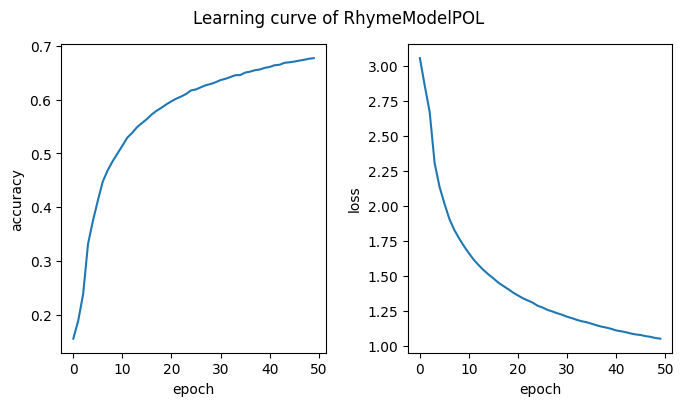

In [20]:
with open(f"data/models/{MODEL_NAME}/history.pickle", "rb") as f:
    history = pickle.load(f)

fig, (ax1, ax2) = plt.subplots(1, 2)
fig.suptitle(f"Learning curve of {MODEL_NAME}")

ax1.plot(history['accuracy'])
ax1.set_xlabel('epoch')
ax1.set_ylabel('accuracy')

ax2.plot(history['loss'])
ax2.set_xlabel('epoch')
ax2.set_ylabel('loss')
fig.tight_layout()
fig.set_size_inches(7, 4)
fig.savefig(f"data/models/{MODEL_NAME}/learning_curve.png")
plt.show()

In [57]:
for _ in range(10):
  print(generate_rhyme(MODEL, random.choice(list(RHYMES.keys()))))

rumieniec powiedzieniec
wodę wodę
lecieli wieli
rozwinął przesiedniął
marli pożarli
poganinie pogolinie
jezuskiem szluniem
żadna pochodadna
ostateczna wieczna
krzyżują przyprzebają


In [56]:
def measure_modified_levenshtein_score(model: keras.Model, rhymes: dict, pl: bool, tests: int = 100):
    result = []
    for _ in tqdm(range(tests)):
        word = random.choice(list(rhymes.keys()))
        rhyme = generate_rhyme(model, word).split(' ')[-1]
        result.append(rhyme_levenshtein_measure(word, rhyme, pl))
    result = list(filter(lambda x: x==x, result))
    return np.mean(result)

def measure_ipa_score(model: keras.Model, rhymes: dict, pl: bool, tests: int = 100):
    result = []
    epi = epitran.Epitran('pol-Latn' if pl else 'eng-Latn')
    for _ in tqdm(range(tests)):
        word = random.choice(list(rhymes.keys()))
        rhyme = generate_rhyme(model, word).split(' ')[-1]
        n_letters = min(len(word), len(rhyme), 3) # Check max 4 last letters
        if not pl and not eng_to_ipa.convert(rhyme).endswith('*'):
            word_ipa = eng_to_ipa.convert(word[-n_letters:])
            rhyme_ipa = eng_to_ipa.convert(rhyme[-n_letters:])
        else:
            try:
                word_ipa = epi.transliterate(word[-n_letters:])
                rhyme_ipa = epi.transliterate(rhyme[-n_letters:])
            except IndexError as e:
                continue
        result.append(1 - lev(word_ipa, rhyme_ipa) / max(len(word_ipa), len(rhyme_ipa)))
    return np.mean(result)

print(f"Modified levenshtein rhyming score: {measure_modified_levenshtein_score(MODEL, RHYMES, POL)}")
print(f"Transliteration rhyming score: {measure_ipa_score(MODEL, RHYMES, POL)}")

100%|██████████| 100/100 [01:39<00:00,  1.00it/s]


Modified levenshtein rhyming score: 0.6954880952380954


100%|██████████| 100/100 [01:34<00:00,  1.06it/s]

Transliteration rhyming score: 0.8859999999999999
